In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate

In [4]:
train_df = pd.read_csv('train_df_doordash_pre_imp_scaling.csv')
test_df = pd.read_csv('test_df_doordash_pre_imp_scaling.csv')

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_min,slow_order,market_id_1,market_id_2,market_id_3,market_id_4,market_id_5,market_id_6,order_protocol_1,order_protocol_2,order_protocol_3,order_protocol_4,order_protocol_5,order_protocol_6,order_protocol_7,created_hour,created_weekend
0,1,760,1,760,760,20.0,20.0,21.0,251,810.0,45.47,0,0,0,1,0,0,0,0,0,0,1,0,0,0,19,1
1,2,2266,1,856,949,54.0,40.0,64.0,251,525.0,48.25,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2,5,3585,4,150,1295,22.0,14.0,22.0,251,216.0,56.03,1,0,0,0,0,1,0,0,0,0,0,1,0,0,2,0
3,1,1050,1,1050,1050,15.0,14.0,16.0,251,773.0,36.33,0,0,1,0,0,0,0,0,1,0,0,0,0,0,23,0
4,4,3635,3,450,1825,5.0,3.0,3.0,446,236.0,67.27,1,0,0,1,0,0,0,1,0,0,0,0,0,0,3,0


In [7]:
train_df.columns

Index(['total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'delivery_duration_min',
       'slow_order', 'market_id_1', 'market_id_2', 'market_id_3',
       'market_id_4', 'market_id_5', 'market_id_6', 'order_protocol_1',
       'order_protocol_2', 'order_protocol_3', 'order_protocol_4',
       'order_protocol_5', 'order_protocol_6', 'order_protocol_7',
       'created_hour', 'created_weekend'],
      dtype='object')

Our binary response variable which we created is slow_order. As described in the Data Preprocessing section, slow_order is binary and indicates a delivery whose duration (in minutes) exceeds the 66th percentile of delivery times, which is approximately past the 51 minute mark.

Since delivery_duration_min was used for linear regression and provides direct information about the true delivery time, we remove it to prevent data leakage in our model.

In [8]:
train_df.drop(['delivery_duration_min'], axis=1, inplace=True)
test_df.drop(['delivery_duration_min'], axis=1, inplace=True)

In [9]:
X_train = train_df.drop("slow_order", axis=1)
y_train = train_df["slow_order"]

X_test = test_df.drop("slow_order", axis=1)
y_test = test_df["slow_order"]

In [10]:
X_train.dtypes

,0
total_items,int64
subtotal,int64
num_distinct_items,int64
min_item_price,int64
max_item_price,int64
total_onshift_dashers,float64
total_busy_dashers,float64
total_outstanding_orders,float64
estimated_order_place_duration,int64
estimated_store_to_consumer_driving_duration,float64


We see that some of these objects are floats. However, we want to make them integers, which we do below

In [11]:
int_cols = ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders','estimated_store_to_consumer_driving_duration']

for col in int_cols:
  train_df[col] = train_df[col].astype("Int64") # since some columns till holds NA values, once imputed will become int64
  test_df[col] = test_df[col].astype("Int64")

In [14]:
def run_cv(model):
  pipeline = Pipeline([ # creating pipeline for imputation and scaling within each fold without leaking data
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", model)
  ])

  cv_results = cross_validate( # cross-validation
    pipeline,
    X_train, y_train,
    cv=5,
    scoring=["accuracy", "precision", "recall", "f1"],
    return_train_score=False
  )

  avg_metrics = {
    "accuracy": cv_results["test_accuracy"].mean(),
    "precision": cv_results["test_precision"].mean(),
    "recall": cv_results["test_recall"].mean(),
    "f1": cv_results["test_f1"].mean()
  }
  print(f"CV Results for penalty = {model.penalty}") # printing average metrics after all folds
  for k, v in avg_metrics.items():
    print(f"Mean CV {k}: {v}")

  return avg_metrics

In [15]:
cv_none = run_cv(LogisticRegression(penalty=None, random_state=42))
cv_l2 = run_cv(LogisticRegression(penalty="l2", random_state=42))
cv_l1 = run_cv(LogisticRegression(penalty="l1", solver ="liblinear", random_state=42))
cv_elastic = run_cv(LogisticRegression(penalty="elasticnet", l1_ratio=0.5, solver="saga", random_state=42))

CV Results for penalty = None
Mean CV accuracy: 0.7302197801032482
Mean CV precision: 0.6656608954918936
Mean CV recall: 0.4114902480510276
Mean CV f1: 0.5085788803627429
CV Results for penalty = l2
Mean CV accuracy: 0.7301942344643612
Mean CV precision: 0.665640824873603
Mean CV recall: 0.411377305102764
Mean CV f1: 0.5084864757622749
CV Results for penalty = l1
Mean CV accuracy: 0.730226167226729
Mean CV precision: 0.6657512304319655
Mean CV recall: 0.41135847802976616
Mean CV f1: 0.5085052909031541
CV Results for penalty = elasticnet
Mean CV accuracy: 0.7302261666149354
Mean CV precision: 0.6657619358033051
Mean CV recall: 0.41133965450035437
Mean CV f1: 0.5084939523516478


Overall, across all four logistic regression variants we tried (no penalty, L2, L1, and elastic net), the cross-validated accuracy, precision, recall, and F1-score were essentially identical. This indicates that the regularization type has minimal impact on model performance for our dataset, likely because most predictors are not highly collinear (as we saw in our EDA/Data Preprocessing) and the model is already relatively stable. The uniformly low recall and F1-scores are consistent with our dataset's class imbalance, which in our case shows that a default threshold of 0.5 tends to under-predict the minority class. We did not explore alternate values of the regularization strength because the nearly identical performance across all penalty types suggests that regularization is not a limiting factor in this problem. Based on these results, we will use the L2-penalized logistic regression model, as it is stable, can handle multicollinearity better than L1, and avoids the added complexity that Elastic net adds (with no clear performance difference). Additionally, we use L2 regularization over no penalty just as a precaution to ensure that coefficients are stable/not inflated. Threshold tuning will be applied below to better handle class imbalance.

### Cross-Validation per Fold Metrics

In [16]:
# separate function specifically for cross-val and seeing per fold data once we established that we would use L2 regularization
def run_cv_checkin_metrics(model):
  pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", model)
  ])

  cv_results = cross_validate(
    pipeline,
    X_train, y_train,
    cv=5,
    scoring=["accuracy", "roc_auc"],
    return_train_score=False
  )

  print("Accuracy per fold:", cv_results["test_accuracy"])
  print("AUC per fold:", cv_results["test_roc_auc"])
  print("Mean Accuracy:", np.mean(cv_results["test_accuracy"]))
  print("Mean AUC:", np.mean(cv_results["test_roc_auc"]))

  return cv_results

run_cv_checkin_metrics(LogisticRegression(penalty="l2", random_state=42))

Accuracy per fold: [0.72794329 0.73001884 0.72880544 0.73400179 0.73020181]
AUC per fold: [0.75444858 0.75808176 0.75740161 0.75921898 0.75871305]
Mean Accuracy: 0.7301942344643612
Mean AUC: 0.7575727968389856


{'fit_time': array([1.62511039, 1.13495135, 1.11331749, 0.96773076, 1.06020021]),
 'score_time': array([0.12886095, 0.04453683, 0.04600978, 0.04341459, 0.09714484]),
 'test_accuracy': array([0.72794329, 0.73001884, 0.72880544, 0.73400179, 0.73020181]),
 'test_roc_auc': array([0.75444858, 0.75808176, 0.75740161, 0.75921898, 0.75871305])}

This shows the same exact results as above, but just more in depth per fold. We can see that **FINISH**

## Threshold

Because our dataset is imbalanced (around 34% of the data are slow orders), we use the positive-class prevalence as our decision threshold rather than the default 0.5. This balances the predicted class frequencies and increases the sensitivity of our model to slow orders.

In [17]:
threshold = train_df['slow_order'].mean()
print("Positive class rate:", threshold)

Positive class rate: 0.3392705466110625


As such, we will use a decision threshold of approximately 0.34.

## Fully Trained Logistic Regression Model

In [18]:
final_model = Pipeline([
  ("imputer", SimpleImputer(strategy="median")),
  ("scaler", StandardScaler()),
  ("clf", LogisticRegression()) # default penalty is L2
])
final_model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('clf', LogisticRegression())])

## Metrics

### Training Data

Training Accuracy: 0.6955927527253917
Training Error: 0.30440724727460833
True Positive Rate (TPR): 0.6718997063474136
True Negative Rate (TNR): 0.7077586290221247


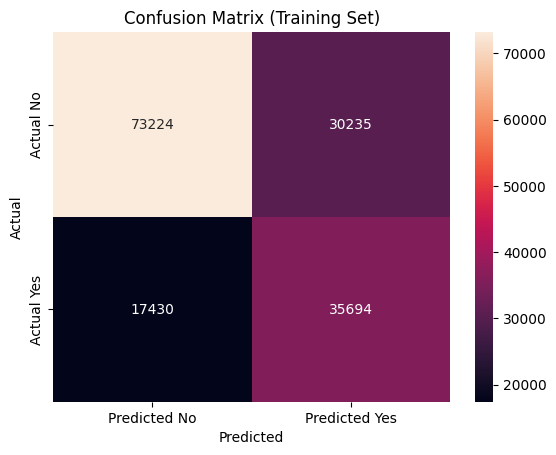

In [19]:
y_prob_train = final_model.predict_proba(X_train)[:, 1]
y_pred_train = (y_prob_train >= threshold).astype(int)

cm_train = confusion_matrix(y_train, y_pred_train)
tn, fp, fn, tp = cm_train.ravel()

train_accuracy = accuracy_score(y_train, y_pred_train)
train_error = 1 - train_accuracy
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

print("Training Accuracy:", train_accuracy)
print("Training Error:", train_error)
print("True Positive Rate (TPR):", tpr)
print("True Negative Rate (TNR):", tnr)

sns.heatmap(cm_train, annot=True, fmt="d", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.title("Confusion Matrix (Training Set)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

We can see that the model performs reasonably fairly at identifying both slow and non-slow orders, achieving a balanced true positive rate (around 0.67) and true negative rate (around 0.71). The training confusion matrix shows that the model correctly classifies a large majority of observations, though misclassifications still occur in both directions, reflecting the inherent difficulty of the task

### Testing Data

In [21]:
y_prob = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= threshold).astype(int)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))

Test Accuracy: 0.6927713920817369
Test Precision: 0.5381345640029147
Test Recall: 0.6671183378500452
Test F1: 0.5957246571659048


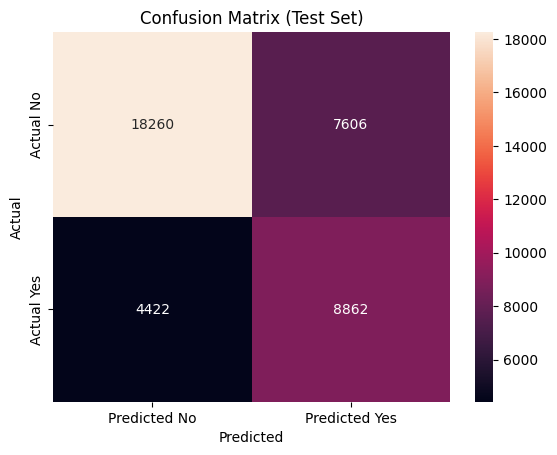

In [22]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.title("Confusion Matrix (Test Set)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

Test ROC-AUC: 0.7556228079849979


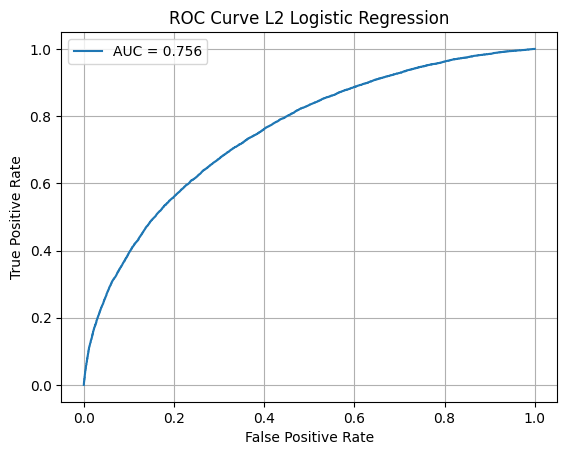

In [23]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
auc = roc_auc_score(y_test, y_prob)
print("Test ROC-AUC:", auc)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve L2 Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

The confusion matrix as well as the corresponding test metrics above provide a clearer picture of how our final model performs using the full training set and adjusted decision threshold. The test accuracy of approximately 69% is reasonable given the class imbalance in the dataset and reflects that the model is not simply overpredicting the majority class. More importantly, the model achieves a recall of approximately .667, which is a substantial improvement compared to the to the 0.41 recall observed during cross-validation with the default threshold (which was evaluated on the training folds). The resulting F1-score of 0.596 reflects a balanced trade-off between precision and recall and indicates that the custom threshold meaningfully improves the model's ability to capture slow deliveries. The ROC curve further supports this conclusion, with an AUC of approximately 0.756 indicating that the model has a moderate ability to discriminate between slow and non-slow deliveries. Additionally, since our test accuracy is only a small improvement over the baseline accuracy (implied by predicting the majority class), this shows that the linear boundary is only partly effective in capturing our data. Overall, the model is still better aligned with our objective of identifying delayed orders, even if this comes with a higher number of false alarms, and shows that the decision boundary is only moderately linear, meaning a more complex/flexible model might be able to perform better.

## Feature Importance

In [24]:
# Components from pipeline
scaler = final_model.named_steps["scaler"]
clf = final_model.named_steps["clf"]

coefs_scaled = clf.coef_[0] # scaled coefficiwnts

feature_names = X_train.columns

# creating a sorted df
coef_df = pd.DataFrame({
  "feature": feature_names,
  "coefficient_scaled": coefs_scaled
}).sort_values(by="coefficient_scaled", ascending=False)

coef_df

,feature,coefficient_scaled
7,total_outstanding_orders,2.252832
9,estimated_store_to_consumer_driving_duration,0.484281
1,subtotal,0.339781
8,estimated_order_place_duration,0.210983
10,market_id_1,0.148434
19,order_protocol_4,0.126655
24,created_weekend,0.073816
15,market_id_6,0.073066
2,num_distinct_items,0.071330
21,order_protocol_6,0.064529


We can see that in terms of feature importance (magnitude of the scaled coefficients), total outstanding orders as well as total onshift dashers are by far the most important predictors. Both of these make sense, since a high number of outstanding orders reflects that the system is currently slow and thus limits order fulfillments, whereas having more dashers available can directly reduce delivery delays by increasing capacity. Additionally, other features that dominate include estimated store-to-consumer driving duration, subtotal, total busy dashers, and estimated order place duration. These are intuitive as well because longer travel distances and larger/complex orders both naturally increase the overall time required for delivery. However, it seems that predictors such as the maximum and minimum item price, as well as most market IDs and order protocols, do not significantly affect our model and therefore likely contribute little to no predictive value beyond the features above (that are related to operation or workload).